In [248]:
# Zavier Morales
# Edouard Mason
from pathlib import Path
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint
from sklearn.dummy import DummyClassifier
# Define global variables & import data

RANDOM_STATE_ID = 100577770

TRAINING_DATA_PATH = Path('dataset', 'bank_06.pkl')
COMPETITION_DATA_PATH = Path('dataset', 'bank_competition.pkl')

training_times = {}
tuning_times = {}
prediction_times = {}

raw_data = pd.read_pickle(TRAINING_DATA_PATH)


<div style= "font-family: 'Georgia', serif;" >

## **EDA**

Our goal in EDA is to ensure the following about our dataset:
* All variables are in numerical format.
* There are no missing values in our dataset.
* Our dataset is well balanced (this is a classification problem since we are predicting whether a customer will subscribe or not)

In [ ]:
# quick look at our dataset to help us determine what to do first (probably convert categorical to numerical)
print("Shape of the dataset:\n", raw_data.shape)
print("\nFirst few rows:\n",raw_data.head())
print("\nList of columns:\n",raw_data.columns)
print("\n\n\nTarget variable:\n",raw_data['deposit'].head())

Shape of the dataset:
 (11000, 17)

First few rows:
    age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes  

List of columns:
 Index(['age', 'job', 'marit

Here we are finding the cardinality & data types of variables in order to determine which variables are object-like vs already numerical.

In [232]:
# Cardinality of variables
unique_counts = raw_data.nunique()
print(unique_counts)
print(raw_data.dtypes)


age            76
job            12
marital         3
education       4
default         2
balance      3783
housing         2
loan            2
contact         3
day            31
month          12
duration     1423
campaign       36
pdays         472
previous       34
poutcome        4
deposit         2
dtype: int64
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
deposit      object
dtype: object


We use one-hot encoding to create new columns for the categorical variables we just identified.
We also check if there are any missing values per column, and luckily we find that there are none.

In [244]:
# Encoding object-type variables (except for deposit, which is our target variable)
df_encoded = pd.get_dummies(raw_data, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome'])
print(df_encoded)

#Converting all boolean columns to integers (1 for True, 0 for False)
df_encoded[df_encoded.select_dtypes(include=['bool']).columns] = df_encoded.select_dtypes(include=['bool']).astype(int)
print("\nColumns in the DataFrame:\n\n",df_encoded.columns)
print("\n\nFirst few rows of the DataFrame:\n\n",df_encoded.head())

#Checking the number of missing values per column
missing_values = df_encoded.isnull().sum()
print("\nMissing values per column:\n\n", missing_values)   #We get 0 for each column so we have no missing values




       age  balance  day  duration  campaign  pdays  previous deposit  \
0       59     2343    5      1042         1     -1         0     yes   
1       56       45    5      1467         1     -1         0     yes   
2       41     1270    5      1389         1     -1         0     yes   
3       55     2476    5       579         1     -1         0     yes   
4       54      184    5       673         2     -1         0     yes   
...    ...      ...  ...       ...       ...    ...       ...     ...   
11157   33        1   20       257         1     -1         0      no   
11158   39      733   16        83         4     -1         0      no   
11159   32       29   19       156         2     -1         0      no   
11160   43        0    8         9         2    172         5      no   
11161   34        0    9       628         1     -1         0      no   

       job_admin.  job_blue-collar  ...  month_jun  month_mar  month_may  \
0               1                0  ...        

The issue with the *pdays* variable is that the variable encodes multiple meanings: the duration between contacts and the status of the contact. Instead, we must figure out a way to modify *pdays* or create new columns to preserve the different meanings while maintaining that 1) the variables are numerical and 2) only encodes one meaning.

In [ ]:
# Filter rows where pdays == -1
count_minus1 = (raw_data['pdays'] == -1).sum()

print(count_minus1)

# We see that there are 8203 where pdays = -1, that is where we have no info or contact. 


8203


Our method is to create a new dummy variable *prev_contacted* where 1 means the value for *pdays* was not -1, and 0 where it was -1. This dummy variable only encodes the status of the contact with the customer, and satisfies our two criteria above (numerical and encodes one meaning).

We then replace *pdays* with *pdays_duration* where all values that were originally -1 are instead the median of all positive *pdays* values. This new variable is both numerical and only encodes one meaning (contact duration) which satisfies our two criteria above. Given that -1 means either we don't know the outcome or we know the customer never resonded, then using the median duration period assumes that these customers are likely similar enough to the average customer who did respond.

In [245]:
# We create a new binary column with value = 1 if previously contacted and 0 if pdays = -1 (no previous contact)
df_encoded["prev_contacted"] = (df_encoded["pdays"] != -1).astype(int)
# We only calculate the median on values greater than -1
known_pdays = df_encoded.loc[df_encoded['pdays'] != -1, "pdays"]
median_pdays = known_pdays.median()
print(median_pdays)

# We replace all -1 values with the median of the know_pdays
df_encoded['pdays_duration'] = df_encoded['pdays'].replace(-1, median_pdays)
print(df_encoded['pdays_duration'].tail())
print(df_encoded.tail())

# We drop the original pdays variable
df_encoded.drop('pdays', axis=1, inplace=True)

182.0
11157    182
11158    182
11159    182
11160    172
11161    182
Name: pdays_duration, dtype: int64
       age  balance  day  duration  campaign  pdays  previous deposit  \
11157   33        1   20       257         1     -1         0      no   
11158   39      733   16        83         4     -1         0      no   
11159   32       29   19       156         2     -1         0      no   
11160   43        0    8         9         2    172         5      no   
11161   34        0    9       628         1     -1         0      no   

       job_admin.  job_blue-collar  ...  month_may  month_nov  month_oct  \
11157           0                1  ...          0          0          0   
11158           0                0  ...          0          0          0   
11159           0                0  ...          0          0          0   
11160           0                0  ...          1          0          0   
11161           0                0  ...          0          0          0   

After we have all of our training variables cleaned and in the format we want them in, we finally convert our target variable *deposit* to a binary integer value. Then, to prepare our data for training and test validation using the holdout method, we divide our data into "attributes" and "class" sets, and then divide those sets into "test" and "training".

In order to scale our numerical/continuous columns (excluding the categorical columns created with one-hot encoding), we use a transformer to discriminate and scale the numerical columns.

In [246]:
#We convert yes to 1 and no to 0 for the target 'deposit'
df_encoded["deposit"] = df_encoded["deposit"].map({"yes": 1, "no": 0}) #Used AI to convert yes to 1 and no to 0 in the target column 'deposit'

y = df_encoded["deposit"]
X = df_encoded.drop("deposit", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE_ID)

num_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'previous', 'pdays_duration']
cat_cols = [col for col in df_encoded.columns if col not in num_cols and col != 'deposit']  # Used AI to create the loop selecting all columns that are not in num_cols and are not 'deposit'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols), 
        ('cat', 'passthrough', cat_cols) 
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)



We also want to consider if our data is imbalanced or not. From the graph below, we can see that the distribution of the classes for our target variable are relatively evenly distributed. When we calculate the proportion of each class, we can see that the 0 class only makes up about 53% of the total distribution, meaning that we should aim for our model to have an accuracy greater than 52%. This is to say that our dataset is not imbalanced as long as we don't have a model that performs incredibly poorly

0.52545


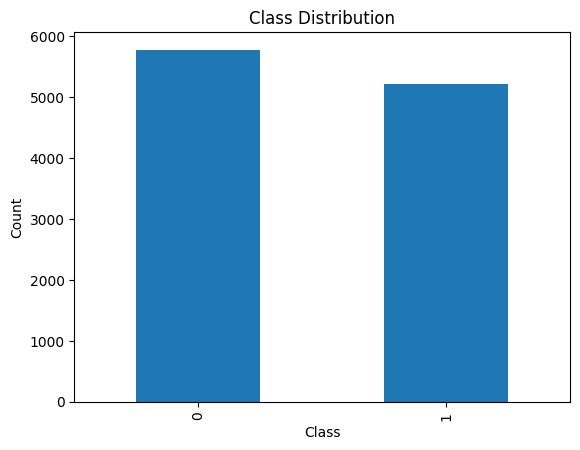

In [269]:
print(round(y.value_counts()[0]/y.count(), 5))

pd.Series(y).value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


Our test partition is 20% of the overall dataset. A rule of thumb when deciding the test size for the holdout method is that as the size of the dataset increases, the size of the test partition is able to become smaller while still maintaining the same margin of error for measuring the estimated accuracy. With the below calculated margins of error [insert Edouard magic here], we can see that with our dataset size (11,000 observations), we should still expect a reasonable margin of error when validating the performance of the model with the test set.

In [ ]:
# [Insert Edouard magic here]
num_test = y_test.count()
print(f"Observations in test: {num_test}",
      f"\nObservations in train: {11000 - num_test}")

Observations in test: 2200 
Observations in train: 8800


<div style= "font-family: 'Georgia', serif;" >


### **Logistic Regression**

In [125]:
logreg = LogisticRegression(random_state=RANDOM_STATE_ID)

start_time = time.time()
logreg.fit(X_train_processed, y_train)
training_times["lr"] = time.time() - start_time

y_pred_log = logreg.predict(X_test_processed)

accuracy_log = accuracy_score(y_test, y_pred_log)

print(accuracy_log)




0.8181818181818182


In [127]:
#Confidence Interval

n = len(y_test)
z = 1.96

se_log = np.sqrt((accuracy_log*(1-accuracy_log))/n) 

ci_upper = accuracy_log + se_log*z
ci_lower = accuracy_log - se_log*z

print(ci_lower, ci_upper)

0.8020646663080251 0.8342989700556114


<div style= "font-family: 'Georgia', serif;" >


### **KNN**

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)

start_time = time.time()
knn.fit(X_train_processed, y_train)
training_times["knn"] = time.time() - start_time

y_pred_knn = knn.predict(X_test_processed)

accuracy_knn = accuracy_score(y_test, y_pred_knn)

print(accuracy_knn)


0.7995454545454546


In [128]:
#Confidence Interval

n = len(y_test)
z = 1.96

se_knn = np.sqrt((accuracy_knn*(1-accuracy_knn))/n) 

ci_upper = accuracy_knn + se_knn*z
ci_lower = accuracy_knn - se_knn*z

print(ci_lower, ci_upper)

0.7828162895473836 0.8162746195435255


<div style= "font-family: 'Georgia', serif;" >


### **Tree** 

In [ ]:
tree = DecisionTreeClassifier()

start_time = time.time()
tree = tree.fit(X_train_processed, y_train)
training_times["tree"] = time.time() - start_time

y_pred_tree = tree.predict(X_test_processed)

accuracy_tree = accuracy_score(y_test, y_pred_tree)

print(accuracy_tree)

0.7777272727272727


In [129]:
#Confidence Interval

n = len(y_test)
z = 1.96

se_tree = np.sqrt((accuracy_tree*(1-accuracy_tree))/n) 

ci_upper = accuracy_tree + se_tree*z
ci_lower = accuracy_tree - se_tree*z

print(ci_lower, ci_upper)

0.7603532060274768 0.7951013394270686


<div style= "font-family: 'Georgia', serif;" >


### **Dummy Classifier**

In [142]:
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)

print(accuracy_dummy)

0.519090909090909


<div style= "font-family: 'Georgia', serif;" >



## **Hyperparameter Tuning**

<div style= "font-family: 'Georgia', serif;" >



### **Logistic Regression**

In [ ]:

param_grid_lr = {
    'C' : np.logspace(-4, 4, 20), 
    'penalty': ['l2'],             
    'solver': ['lbfgs', 'liblinear'] 
}

logistic = LogisticRegression(random_state=RANDOM_STATE_ID, max_iter=1000)

# Find best hyperparameters using RandomizedSearchCV
grid_search = GridSearchCV(logistic, param_grid=param_grid_lr, 
                                     cv=5,
                                   scoring='f1',
                                    n_jobs=1
)

# Train the model with best hyperparameters
start_time = time.time()
grid_search.fit(X_train_processed, y_train)
tuning_times["lr"] = time.time() - start_time
best_params= grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters (Random Search): {best_params}")
print(f"Best Score (Random Search): {best_score}")

Best Parameters (Random Search): {'C': np.float64(4.281332398719396), 'penalty': 'l2', 'solver': 'lbfgs'}
Best Score (Random Search): 0.8185949201235179


In [ ]:
# Find accuracy over entire training set
tuned_lr = grid_search.best_estimator_
y_pred_tuned = tuned_lr.predict(X_test_processed)
accuracy_tuned_lr = accuracy_score(y_pred_tuned,y_test )

print(accuracy_tuned_lr)
print(tuning_times)

0.8154545454545454
{'lr': 8.165611743927002}


In [130]:
#Confidence Interval

n = len(y_test)
z = 1.96

se_log_tuned = np.sqrt((accuracy_tuned_lr*(1-accuracy_tuned_lr))/n) 

ci_upper = accuracy_tuned_lr + se_log_tuned*z
ci_lower = accuracy_tuned_lr - se_log_tuned*z

print(ci_lower, ci_upper)

0.7992440500925958 0.8316650408164951


<div style= "font-family: 'Georgia', serif;" >



### **KNN**

In [ ]:
param_grid_knn = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

knn = KNeighborsClassifier()

#Tuning using RandomizedSearchCV
grid_search_knn = GridSearchCV(knn, param_grid=param_grid_knn, 
                                cv=5, scoring="accuracy", 
                                n_jobs=1
)

start_time = time.time()
grid_search_knn.fit(X_train_processed, y_train)
tuning_times["knn"] = time.time() - start_time
best_params= grid_search_knn.best_params_
best_score = grid_search_knn.best_score_

print(f"Best Parameters (Random Search): {best_params}")
print(f"Best Score (Random Search): {best_score}")


Best Parameters (Random Search): {'metric': 'minkowski', 'n_neighbors': 15, 'weights': 'distance'}
Best Score (Random Search): 0.8103409090909091


In [ ]:
tuned_knn = grid_search_knn.best_estimator_
y_pred_tuned = tuned_knn.predict(X_test_processed)
accuracy_tuned_knn = accuracy_score(y_pred_tuned, y_test)

print(accuracy_tuned_knn)
print(tuning_times)

0.8163636363636364
{'lr': 8.165611743927002, 'knn': 10.731130123138428}


In [131]:
#Confidence Interval

n = len(y_test)
z = 1.96

se_knn_tuned = np.sqrt((accuracy_tuned_knn*(1-accuracy_tuned_knn))/n) 

ci_upper = accuracy_tuned_knn + se_knn_tuned*z
ci_lower = accuracy_tuned_knn - se_knn_tuned*z

print(ci_lower, ci_upper)

0.8001531410016868 0.832574131725586


<div style= "font-family: 'Georgia', serif;" >


### **Decision Tree**

In [ ]:
param_dist_tree = {
     'criterion': ['gini', 'entropy'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}
tree = DecisionTreeClassifier(random_state=RANDOM_STATE_ID)

#Tuning using RandomizedSearchCV
random_search_tree = RandomizedSearchCV(tree, param_distributions=param_dist_tree, 
                                   cv=3, scoring='accuracy',
                                   n_iter=50, random_state=RANDOM_STATE_ID,
                                   n_jobs=1
)

start_time = time.time()
random_search_tree.fit(X_train_processed, y_train)
tuning_times["tree"] = time.time() - start_time
best_params= random_search_tree.best_params_
best_score = random_search_tree.best_score_

print(f"Best Parameters (Random Search): {best_params}")
print(f"Best Score (Random Search): {best_score}")

Best Parameters (Random Search): {'criterion': 'gini', 'max_depth': 13, 'min_samples_leaf': 18, 'min_samples_split': 3}
Best Score (Random Search): 0.8294310648952874


In [ ]:
tuned_tree = random_search_tree.best_estimator_
y_pred_tuned = tuned_tree.predict(X_test_processed)

accuracy_tree_tuned = accuracy_score(y_pred_tuned, y_test)

print(accuracy_tree_tuned)
print(tuning_times)


0.8368181818181818
{'lr': 8.165611743927002, 'knn': 10.731130123138428, 'tree': 3.6735360622406006}


In [132]:
#Confidence Interval

n = len(y_test)
z = 1.96

se_tree_tuned = np.sqrt((accuracy_tree_tuned*(1-accuracy_tree_tuned))/n) 

ci_upper = accuracy_tree_tuned + se_tree_tuned*z
ci_lower = accuracy_tree_tuned - se_tree_tuned*z

print(ci_lower, ci_upper)

0.8213764442036524 0.8522599194327112


<div style= "font-family: 'Georgia', serif;" >


### **Dummy Classifier**

In [141]:
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)

print(accuracy_dummy)

0.519090909090909




<div style= "font-family: 'Georgia', serif;" >

## **Advanced Models**

<div style= "font-family: 'Georgia', serif;" >

### **SVM**

In [ ]:
from sklearn.svm import SVC

svm_model = SVC(random_state=RANDOM_STATE_ID)

start_time = time.time()

svm_model.fit(X_train_processed, y_train)
training_times["svm_model"] = time.time() - start_time

y_pred_svm = svm_model.predict(X_test_processed)

accuracy_svm = accuracy_score(y_pred_svm, y_test)

print("SVM Accuracy Score:", accuracy_svm)
                  

SVM Accuracy Score: 0.8563636363636363


In [135]:
#Confidence Interval

n = len(y_test)
z = 1.96

se_svm = np.sqrt((accuracy_svm*(1-accuracy_svm))/n) 

ci_upper = accuracy_svm + se_svm*z
ci_lower = accuracy_svm- se_svm*z

print(ci_lower, ci_upper)

0.8417079541076244 0.8710193186196482


In [ ]:
#Tuned SVM

param_grid = {'C': [0.1, 1, 10, 100, 1000], 
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
			'kernel': ['rbf']} 

grid_search = GridSearchCV(SVC(), param_grid, refit = True, n_jobs=-1) 

grid_search.fit(X_train_processed, y_train)

print(f'Best parameter is {grid_search.best_params_}')
print(f'Best score is {grid_search.best_score_}')



Best parameter is {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best score is 0.85375


In [ ]:
tuned_svm = grid_search.best_estimator_

y_pred_tuned_svm = tuned_svm.predict(X_test_processed)

accuracy_tuned_svm = accuracy_score(y_pred_tuned_svm, y_test)

print(f"Tuned SVM Accuracy score: {accuracy_tuned_svm:.4f}")

Tuned SVM Accuracy score: 0.8582


In [133]:
#Confidence Interval

n = len(y_test)
z = 1.96

se_svm_tuned = np.sqrt((accuracy_tuned_svm*(1-accuracy_tuned_svm))/n) 

ci_upper = accuracy_tuned_svm + se_svm_tuned*z
ci_lower = accuracy_tuned_svm- se_svm_tuned*z

print(ci_lower, ci_upper)

0.8436037377474463 0.87275989861619


<div style= "font-family: 'Georgia', serif;" >

### **Random Forest Classifier**


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=RANDOM_STATE_ID)
start_time = time.time()

rf.fit(X_train_processed, y_train)
training_times["rf"] = time.time() - start_time

y_pred_rf= rf.predict(X_test_processed)

accuracy_rf = accuracy_score(y_pred_rf, y_test)

print("Random Forest Accuracy score:", accuracy_rf)

Random Forest Accuracy score: 0.8522727272727273


In [136]:
#Confidence Interval

n = len(y_test)
z = 1.96

se_rf = np.sqrt((accuracy_rf*(1-accuracy_rf))/n) 

ci_upper = accuracy_rf + se_rf*z
ci_lower = accuracy_rf- se_rf*z

print(ci_lower, ci_upper)

0.8374453490231826 0.867100105522272


<div style= "font-family: 'Georgia', serif;" >

### **XGBoost**

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=100,        
    max_depth=6,             
    learning_rate=0.1,      
    objective='binary:logistic', 
    random_state=RANDOM_STATE_ID
)

start_time = time.time()
xgb_model.fit(X_train_processed, y_train)
training_times["xgb_model"] = time.time() - start_time
y_pred_xgb = xgb_model.predict(X_test_processed)

accuracy_xgb = accuracy_score(y_pred_xgb, y_test)

print("XGBoost accuracy score:", accuracy_xgb)
print(training_times)



XGBoost accuracy score: 0.8563636363636363
{'lr': 0.06198596954345703, 'knn': 0.0045130252838134766, 'tree': 0.092742919921875, 'svm_model': 1.0750370025634766, 'rf': 0.756624698638916, 'xgb_model': 0.1907200813293457}


In [137]:
#Confidence Interval

n = len(y_test)
z = 1.96

se_xgb = np.sqrt((accuracy_xgb*(1-accuracy_xgb))/n) 

ci_upper = accuracy_xgb + se_xgb*z
ci_lower = accuracy_xgb- se_xgb*z

print(ci_lower, ci_upper)

0.8417079541076244 0.8710193186196482


In [ ]:
#Tuned XGboost 

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}

xgb_model = xgb.XGBClassifier()

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_processed, y_train)

print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)



Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.7}
Best score:  0.8635227272727273


In [ ]:
tuned_xgb = grid_search.best_estimator_

y_pred_tuned_xgb = tuned_xgb.predict(X_test_processed)

accuracy_tuned_xgb = accuracy_score(y_pred_tuned_xgb, y_test)

print(f"Accuracy Tuned XGB:, {accuracy_tuned_xgb:.4f}")

Accuracy Tuned XGB:, 0.8600


In [134]:
#Confidence Interval

n = len(y_test)
z = 1.96

se_xgb_tuned = np.sqrt((accuracy_tuned_xgb*(1-accuracy_tuned_xgb))/n) 

ci_upper = accuracy_tuned_xgb + se_xgb_tuned*z
ci_lower = accuracy_tuned_xgb - se_xgb_tuned*z

print(ci_lower, ci_upper)

0.8455003348001034 0.8744996651998965


<div style= "font-family: 'Georgia', serif;" >


## **Results**

In [ ]:
%pip install tabulate
import tabulate

## Results to report (in a table):

# by model (KNN, LR, DT)
models = ['Logistic Regression', 'KNN', 'Decision Tree']

# confidence intervals (RMSE)
#  before hyperparameter tuning
accuracies = [accuracy_log, accuracy_knn, accuracy_tree]
#  after hyperparameter tuning
tuned_accuracies = [accuracy_tuned_lr, accuracy_tuned_knn, accuracy_tree_tuned]
# accuracy improvement
accuracy_improvement = [(tuned_accuracies[idx] - acc) / acc for idx, acc in enumerate(accuracies)]

# training time
training_times
# hyperparam tuning time
tuning_times


headings = [
    'Model',
    'Accuracy without hyperparameter tuning (%)',
    'Accuracy after hyperparameters tuning (%)',
    'Accuracy improvement (%)',
    'Training time (s)',
    'Hyperparameter tuning time (s)',
]

data = [
    models,
    accuracies,
    tuned_accuracies,
    accuracy_improvement,
    [training_times[key] for key in ['lr', 'knn', 'tree']],
    [tuning_times[key] for key in ['lr', 'knn', 'tree']],
]

# round all numbered data
data = [[round(e, 4) for e in col] if type(col[0]) is not str else col for col in data]

data = np.array(data).transpose()

print(tabulate.tabulate(data, headers=headings))

# draw conclusions about different models (which ones benefited the most from hyper-tuning, speed, etc.)

Note: you may need to restart the kernel to use updated packages.
Model                  Accuracy without hyperparameter tuning (%)    Accuracy after hyperparameters tuning (%)    Accuracy improvement (%)    Training time (s)    Hyperparameter tuning time (s)
-------------------  --------------------------------------------  -------------------------------------------  --------------------------  -------------------  --------------------------------
Logistic Regression                                        0.8182                                       0.8155                     -0.0033               0.062                             8.1656
KNN                                                        0.7995                                       0.8164                      0.021                0.0045                           10.7311
Decision Tree                                              0.7777                                       0.8368                      0.076                0.092

<div style= "font-family: 'Georgia', serif;" >

## **Results**

| Model | Accuracy - no hyperparameter tuning |95 % Confidence Interval| Accuracy - tuned hyperparameters |95% Confidence Interval| Accuracy Improvement (%)| Training time (s) | Hyperparameter tuning time (s)|
|-------|--------|---------|----------|-----------|------------|--------|-------|
|Logistic Regression|0.8182|[0.802, 0.834]|0.8155|[0.799, 0.8317]|-3.3|0.0529|5.3054|
|KNN|0.7995|[0.783, 0.816]|0.8164|[0.800, 0.8326]|2.1|0.0039|16.8341|
|Decision Tree|0.785|[0.7604, 0.7951]|0.8368|[0.8214, 0.8523]|6.6|0.0802|4.9904|
|SVM|0.8564|[0.8417, 0.871]|0.8582|[0.8436, 0.873]|0.21|1.257|84|
|Random Forest|0.8522|[0.837, 0.867]|/|/|/|1.02|/|
|XGboost|0.8564|[0.8417, 0.871]|0.86|[0.8455, 0.8745]|0.42|0.268|21|

<div style="max-width: 1000px; font-family: 'Georgia', serif; font-size: 14px; line-height: 1.6;">


## **Comments**

### <u>**Base Models**</u>
From the above table, we note that out off the base models, the logistic regression performed the best with an accuracy score of 81.8 %. Then came the KNN method and finally the Decision Tree with accuracies of 79.95% and 78.5% respectively. 



#### **After hyperparameter tuning** 
After hyperparameter tuning, the Decision Tree method achieved both the overall highest accuracy of all base models with 83.68% 
and the greatest improvement in accuracy (6.6%). A surprising result comes from the Logistic Regression, who displayed a decrease of 3.3% in accuracy after tuning the hyperparameters.


#### **Tuning time** 
Overall, it is also the Decision Tree model that displayed the lowest hyperparameter tuning time with 4.99 seconds compared to 5.3 seconds 
for the Logistic Regression and a much higher value of 16.8 seconds for KNN.

### <u>**Advanced Models**</u>

All three of the  (untuned) advanced models performed better than the base models before and after hyperparameter tuning. They all present similar accuracy scores with SVM and XGboost achieving a slightly higher (and identical) accuracy of 85.64 %. 

We checked the confusion matrix for XGboost and SVM and noticed that they had different numbers of correct predictions for class 0 and class 1 (has the client subscribed a term deposit?) but overall achieved the same number of total correct predictions, which explains one they achieved identical accuracy scores.

#### **After hyperparameter tuning**

We decide to tuned the SVM and XGBoost models as they presented the highest accuracy of the advanced models. XGBoost achieved the higher accuracy score increase of the 2 (0.42%), with a final accuracy of 86%. It also had the faster hyperparameter tuning time with 21 seconds compared to 84 seconds for SVM (only improving accuracy by 0.21%)

### <u>**Conclusion**</u>

We conclude that we should use the more advanced prediction models for this problem as they all presented higher accuracy scores than the base models. We would favour the XGboost model as it presented the highest overall accuracy of all models (tuned and untuned) and as tuning was faster for that specifc model. 


</div>


<div style= "font-family: 'Georgia', serif;" >


## **Final Model**

In [ ]:
#Load test dataset

test_set = pd.read_pickle(COMPETITION_DATA_PATH)

print(test_set.columns)

# make predictions about this using the best method

# save final model (in notes)
# save predictions in a file (pkl)

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome'],
      dtype='object')
